# Setup

### Dependencies

In [1]:
# !pip install transformers
# !pip install pandas
# !pip install gdown
# !pip install matplotlib
# !pip install seaborn
# !pip install nltk
# !pip install wordcloud
# !pip install spacy
# !pip install scikit-learn
# !pip install textblob

### Load libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
import spacy
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from transformers import pipeline

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report

import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
# !python -m spacy download en

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Download data


In [5]:
# Download data
!gdown --folder 'https://drive.google.com/drive/folders/1-6zWtQdrVlxNqO_-_9avDnWaMC2lxg0S'

Retrieving folder list
Processing file 1KkQWp6-s7m3fkOVUHwpYvUq_-yumeQsz details-all.csv
Processing file 1qvsotI-hdXQTWzrzXDbPVKqCXXFzo8Ke googleHotel_wholeReview.xlsx
Processing file 1jAqdcC3ZkyByOBw61cy7o0Z5b_nxflnU hotels-london-1704121760126.csv
Processing file 1HzgmINSRzcyr5n3Es4Nuu7lGmmzcOuUi reviews-1703178005771.csv
Processing file 1w9GyqNapinl548GCmjRr7xF6d4jbYu3Z reviews-all.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1KkQWp6-s7m3fkOVUHwpYvUq_-yumeQsz
To: /content/data/details-all.csv
100% 105k/105k [00:00<00:00, 2.40MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qvsotI-hdXQTWzrzXDbPVKqCXXFzo8Ke
To: /content/data/googleHotel_wholeReview.xlsx
100% 34.6k/34.6k [00:00<00:00, 20.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jAqdcC3ZkyByOBw61cy7o0Z5b_nxflnU
To: /content/data/hotels-london-1704121760126.csv
100% 13.9k/13.9k [00:00<00:00, 52.2MB/

In [6]:
!ls data

details-all.csv		      hotels-london-1704121760126.csv  reviews-all.csv
googleHotel_wholeReview.xlsx  reviews-1703178005771.csv


In [7]:
# Create plot's output folder
if not os.path.exists('plots'):
    os.mkdir('plots')

In [8]:
!ls

data  plots  sample_data


# EDA

## 1. Data overview and preprocessing

### 1.1. Reviews data

#### 1.1.1. Read data

In [9]:
!ls data

details-all.csv		      hotels-london-1704121760126.csv  reviews-all.csv
googleHotel_wholeReview.xlsx  reviews-1703178005771.csv


In [10]:
# Load data
data_reviews = pd.read_csv(
    'data/reviews-all.csv',
    header=0
)

data_reviews.head()

,hotel_name,review_text,rating,review_timestamp,trip_type,trip_companions
0,Premier Inn Birmingham South (Longbridge Stati...,I am using the hotel as a base as my partner i...,5.0,2023-11-03,NaN,Couple
1,Premier Inn Birmingham South (Longbridge Stati...,We regularly use this premier inn as my in law...,5.0,2023-10-04,Vacation,Family
2,Premier Inn Birmingham South (Longbridge Stati...,"Only stayed for less than 24 hours, but the pe...",5.0,2023-12-12,NaN,NaN
3,Premier Inn Birmingham South (Longbridge Stati...,"I have stayed at a dozen of premier inns, this...",5.0,2023-12-12,NaN,Couple
4,Premier Inn Birmingham South (Longbridge Stati...,Very basic budget hotel. Booked as local to an...,2.0,2023-12-19,NaN,NaN


#### 1.1.2. Descriptive Statistics


**Data shape**

In [11]:
print('shape:', data_reviews.shape)
print('columns:', data_reviews.columns)

shape: (20508, 6)
columns: Index(['hotel_name', 'review_text', 'rating', 'review_timestamp', 'trip_type',
       'trip_companions'],
      dtype='object')


**Numerical Summary** (`Ratings`)

In [12]:
data_reviews.describe()

,rating
count,20508.000000
mean,3.845329
std,1.380386
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


**Categorical Summary**

In [13]:
data_reviews.describe(include='object')

,hotel_name,review_text,review_timestamp,trip_type,trip_companions
count,20508,20474,20508,10288,11175
unique,200,20466,55,2,4
top,Premier Inn Birmingham South (Longbridge Stati...,"Great prices, even at weekends, with very easy...",2023-01-02,Vacation,Couple
freq,109,2,2979,7538,3917


In [14]:
print('trip_type:', data_reviews.trip_type.unique())
print('trip_companions:', data_reviews.trip_companions.unique())

trip_type: [nan 'Vacation' 'Business']
trip_companions: ['Couple' 'Family' nan 'Friends' 'Solo']


#### 1.1.3. Data Cleaning and Preprocessing

##### Missing values

In [15]:
# Check for missing values
data_reviews.isnull().sum()

hotel_name              0
review_text            34
rating                  0
review_timestamp        0
trip_type           10220
trip_companions      9333
dtype: int64

In [16]:
data_reviews = data_reviews.dropna(subset=['review_text'])
data_reviews.shape

(20474, 6)

The columns `trip_type` and `trip_companions` have a significant number of missing values (`10220` and `9333` respectively), while the column `review_text` also has some empty values (`34` empty strings).

##### Duplicate values

In [17]:
data_reviews.duplicated().sum()

0

##### Data types

In [18]:
# Check current data types of all columns
data_reviews.dtypes

hotel_name           object
review_text          object
rating              float64
review_timestamp     object
trip_type            object
trip_companions      object
dtype: object

In [19]:
# Convert `review_timestamp` column to datetime format for easier time-based analysis
data_reviews.review_timestamp = pd.to_datetime(data_reviews.review_timestamp, format='%Y-%m-%d')

In [20]:
# Processed data types
data_reviews.dtypes

hotel_name                  object
review_text                 object
rating                     float64
review_timestamp    datetime64[ns]
trip_type                   object
trip_companions             object
dtype: object

The processed data types are now appropriate for all colums, each falls into one of these categories:
- Text: `hotel_name`, `review_text`, `trip_type`, `trip_companions`
- Number: `rating`
- Datetime: `review_timestamp`

##### Cleaning text data

In [21]:
class Cleaner:

    def __init__(self):
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
        self.list_stopwords = set(nltk.corpus.stopwords.words('english'))
        self.nlp = spacy.load("en_core_web_sm")

    def clean(self, data, text_field='review_text', is_testing=False):
        self.data = data
        self.text_field = text_field
        self.cleaned_field = text_field + '_cleaned'

        self.data[self.cleaned_field] = self.data[self.text_field]

        # Cleaning text
        for cleanup_method in self.iterate():
            if is_testing:
                if cleanup_method.__name__ != 'remove_empty':
                    cleanup_method()
            else:
                cleanup_method()

        # Preprocess text tokens
        self.data[self.cleaned_field] = self.data[self.cleaned_field].apply(self.preprocessing)

    def iterate(self):
        for cleanup_method in [self.remove_usernames,
                               self.clean_text,
                               self.lower_text,
                               self.remove_empty]:
            yield cleanup_method

    def remove_usernames(self):
        """ remove all user tags that start with @ """
        self.remove_by_regex(re.compile(r"@[^\s]+[\s]?"))

    def clean_text(self):
        """ remove digits and other characters except A-Z a-z and white spaces, replaced by 1 white space """
        self.remove_by_regex(re.compile(r"[^A-Za-z]+"), ' ')

    def lower_text(self):
        """ Format all letters into lowercase """
        self.data[self.cleaned_field] = self.data[self.cleaned_field].str.lower()

    def remove_empty(self):
        self.data.dropna(subset=[self.cleaned_field])

    def preprocessing(self, text):
        """ Tokenize the text string to remove stopwords and apply lemmatization """

        list_tokens = self.tokenize(text)
        list_tokens = self.remove_stopwords(list_tokens)
        list_tokens = self.lemmatize(list_tokens)
        result_text = ' '.join(list_tokens)
        if len(list_tokens) >= 512:
            result_text = self.summarize(result_text)

        return result_text

    def tokenize(self, text, return_as_str=False):
        """ apply word tokenizer of nltk.tokenize to return a list of word tokens in English """

        res = nltk.tokenize.word_tokenize(text)
        if return_as_str:
            res = ' '.join(res)
        return res

    def remove_stopwords(self, list_tokens):
        """ remove all stopwords in the list of stopwords in English from nltk """
        text_non_stopwords = [w for w in list_tokens if w not in self.list_stopwords]
        return text_non_stopwords

    def lemmatize(self, list_tokens):
        """
            Converts word tokens in the list_token to their meaningful base forms, which is called Lemma.
            For example: 'tokens' -> 'token'.
            Lemmatization is computationally expensive since it involves look-up tables and what not.
        """

        list_base_tokens = [self.lemmatizer.lemmatize(w) for w in list_tokens]
        return list_base_tokens

    def summarize(self, text, n=20, max_tokens=512):
        """
            Summarize a text into n sentences.
            This function is not used in this notebook.
        """
        doc = self.nlp(text)
        sentences = [sent.text for sent in doc.sents]
        sentences.sort(key=lambda x: len(x.split()), reverse=True)
        while True:
            summary = ' '.join(sentences[:n])
            if len(self.tokenize(summary)) <= max_tokens:
                break
            else:
                n -= 1
        return summary

    def remove_by_regex(self, regexp, replaced_by=''):
        self.data.loc[:, self.cleaned_field].replace(regexp, replaced_by, inplace=True)



In [22]:
cleaner = Cleaner()
cleaner.clean(data_reviews)

data_reviews[[cleaner.text_field, cleaner.cleaned_field]]

,review_text,review_text_cleaned
0,I am using the hotel as a base as my partner i...,using hotel base partner royal orthopedic hosp...
1,We regularly use this premier inn as my in law...,regularly use premier inn law live nearby rece...
2,"Only stayed for less than 24 hours, but the pe...",stayed le hour person reception welcoming room...
3,"I have stayed at a dozen of premier inns, this...",stayed dozen premier inn top list best stay ex...
4,Very basic budget hotel. Booked as local to an...,basic budget hotel booked local event attendin...
...,...,...
20503,Very nice and comfortable place. Was on a busi...,nice comfortable place business trip location ...
20504,"Staffs were very friendly and helpful, breakfa...",staff friendly helpful breakfast really good r...
20505,I'm totally disappointed with this Premier Inn...,totally disappointed premier inn towel pillow ...
20506,This is an aging hotel. No AC in the room so w...,aging hotel ac room hot sleep traffic could he...


### 1.2. Hotels info data

#### 1.2.1. Read data

In [23]:
# Load data
data_hotels = pd.read_csv(
    'data/details-all.csv',
    header=0
).drop('amenities', axis=1)

data_hotels.head()

,name,address,images_count,popular_amenities,source
0,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google
1,Premier Inn Birmingham City Centre Bridge Stre...,"20 Bridge St, Birmingham B1 2JR, United Kingdom",52,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google
2,Premier Inn Birmingham City Centre (Exchange S...,"6, Exchange Square, The Priory Queensway, Birm...",25,"['Wi-Fi', 'Restaurant']",Google
3,Travelodge Birmingham Central Bull Ring,"Upper Dean St, Birmingham B5 4SG, United Kingdom",2,"['Breakfast', 'Wi-Fi', 'Parking', 'Restaurant']",Google
4,Travelodge Birmingham Central,"230 Broad St, Birmingham B15 1AY, United Kingdom",2,"['Breakfast', 'Wi-Fi', 'Parking', 'Pet-friendly']",Google


#### 1.2.2. Descriptive Statistics


**Data shape**

In [24]:
print('shape:', data_hotels.shape)
print('columns:', data_hotels.columns)

shape: (200, 5)
columns: Index(['name', 'address', 'images_count', 'popular_amenities', 'source'], dtype='object')


**Numerical Summary** (`Ratings`)

In [25]:
data_hotels.describe()

,images_count
count,200.000000
mean,40.810000
std,50.505822
min,0.000000
25%,16.000000
50%,26.000000
75%,44.000000
max,344.000000


**Categorical Summary**

In [26]:
data_hotels.describe(include='object')

,name,address,popular_amenities,source
count,200,200,200,200
unique,200,200,51,1
top,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom","['Wi-Fi', 'Air conditioning', 'Breakfast', 'Re...",Google
freq,1,1,55,200


#### 1.2.3. Data Cleaning and Preprocessing

##### Missing values

In [27]:
# Check for missing values
data_hotels.isnull().sum()

name                 0
address              0
images_count         0
popular_amenities    0
source               0
dtype: int64

##### Duplicate values

In [28]:
data_hotels.duplicated().sum()

0

##### Data types

In [29]:
# Check current data types of all columns
data_hotels.dtypes

name                 object
address              object
images_count          int64
popular_amenities    object
source               object
dtype: object

Convert `popular_amenities` to one-hot encoding

In [30]:
amenities_df = data_hotels['popular_amenities'].apply(lambda x: re.sub(r'[\[\]\'\"]', '', x))
amenities_df = amenities_df.str.get_dummies(sep=',')
amenities_df.columns = amenities_df.columns.str.strip()
amenities_df = amenities_df.groupby(amenities_df.columns, axis=1).sum()

# concat the original data frame with the new `amenities` columns
data_hotel_encoded = pd.concat([data_hotels, amenities_df], axis=1)
data_hotel_encoded.head(100)

,name,address,images_count,popular_amenities,source,Air conditioning,Airport shuttle,Breakfast,Fitness center,Hot tub,Kitchen in rooms,Parking,Pet-friendly,Pool,Restaurant,Spa,Wi-Fi
0,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google,1,0,1,0,0,0,1,0,0,0,0,1
1,Premier Inn Birmingham City Centre Bridge Stre...,"20 Bridge St, Birmingham B1 2JR, United Kingdom",52,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google,1,0,1,0,0,0,1,0,0,0,0,1
2,Premier Inn Birmingham City Centre (Exchange S...,"6, Exchange Square, The Priory Queensway, Birm...",25,"['Wi-Fi', 'Restaurant']",Google,0,0,0,0,0,0,0,0,0,1,0,1
3,Travelodge Birmingham Central Bull Ring,"Upper Dean St, Birmingham B5 4SG, United Kingdom",2,"['Breakfast', 'Wi-Fi', 'Parking', 'Restaurant']",Google,0,0,1,0,0,0,1,0,0,1,0,1
4,Travelodge Birmingham Central,"230 Broad St, Birmingham B15 1AY, United Kingdom",2,"['Breakfast', 'Wi-Fi', 'Parking', 'Pet-friendly']",Google,0,0,1,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"Crowne Plaza Liverpool City Centre, an IHG Hotel","2 St Nicholas Pl, Liverpool L3 1QW, United Kin...",174,"['Spa', 'Pool', 'Hot tub', 'Wi-Fi']",Google,0,0,0,0,1,0,0,0,1,0,1,1
96,The Resident Liverpool,"29 Seel St, Liverpool L1 4AU, United Kingdom",20,"['Wi-Fi', 'Air conditioning', 'Kitchen in rooms']",Google,1,0,0,0,0,1,0,0,0,0,0,1
97,Titanic Hotel Liverpool,"Stanley Dock, Regent Rd, Liverpool L3 0AN, Uni...",34,"['Spa', 'Pool', 'Wi-Fi', 'Air conditioning']",Google,1,0,0,0,0,0,0,0,1,0,1,1
98,Mercure Liverpool Atlantic Tower Hotel,"Chapel St, Liverpool L3 9AG, United Kingdom",0,"['Wi-Fi', 'Air conditioning', 'Breakfast', 'Pa...",Google,1,0,1,0,0,0,1,0,0,0,0,1


In [31]:
print('Popular amenities:', data_hotel_encoded.drop(data_hotels.columns, axis=1).columns.sort_values().values)

Popular amenities: ['Air conditioning' 'Airport shuttle' 'Breakfast' 'Fitness center'
 'Hot tub' 'Kitchen in rooms' 'Parking' 'Pet-friendly' 'Pool' 'Restaurant'
 'Spa' 'Wi-Fi']


### 1.3. Join data

In [32]:
data = pd.merge(data_reviews, data_hotel_encoded, how='inner', left_on='hotel_name', right_on='name')
data

,hotel_name,review_text,rating,review_timestamp,trip_type,trip_companions,review_text_cleaned,name,address,images_count,...,Breakfast,Fitness center,Hot tub,Kitchen in rooms,Parking,Pet-friendly,Pool,Restaurant,Spa,Wi-Fi
0,Premier Inn Birmingham South (Longbridge Stati...,I am using the hotel as a base as my partner i...,5.0,2023-11-03,NaN,Couple,using hotel base partner royal orthopedic hosp...,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,...,1,0,0,0,1,0,0,0,0,1
1,Premier Inn Birmingham South (Longbridge Stati...,We regularly use this premier inn as my in law...,5.0,2023-10-04,Vacation,Family,regularly use premier inn law live nearby rece...,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,...,1,0,0,0,1,0,0,0,0,1
2,Premier Inn Birmingham South (Longbridge Stati...,"Only stayed for less than 24 hours, but the pe...",5.0,2023-12-12,NaN,NaN,stayed le hour person reception welcoming room...,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,...,1,0,0,0,1,0,0,0,0,1
3,Premier Inn Birmingham South (Longbridge Stati...,"I have stayed at a dozen of premier inns, this...",5.0,2023-12-12,NaN,Couple,stayed dozen premier inn top list best stay ex...,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,...,1,0,0,0,1,0,0,0,0,1
4,Premier Inn Birmingham South (Longbridge Stati...,Very basic budget hotel. Booked as local to an...,2.0,2023-12-19,NaN,NaN,basic budget hotel booked local event attendin...,Premier Inn Birmingham South (Longbridge Stati...,"1 High St, Birmingham B31 2UQ, United Kingdom",31,...,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20469,Premier Inn Manchester West Didsbury hotel,Very nice and comfortable place. Was on a busi...,5.0,2019-01-04,NaN,NaN,nice comfortable place business trip location ...,Premier Inn Manchester West Didsbury hotel,"Christie Fields Business Pk, Derwent Ave, Manc...",43,...,1,0,0,0,1,0,0,1,0,1
20470,Premier Inn Manchester West Didsbury hotel,"Staffs were very friendly and helpful, breakfa...",3.0,2021-01-03,NaN,NaN,staff friendly helpful breakfast really good r...,Premier Inn Manchester West Didsbury hotel,"Christie Fields Business Pk, Derwent Ave, Manc...",43,...,1,0,0,0,1,0,0,1,0,1
20471,Premier Inn Manchester West Didsbury hotel,I'm totally disappointed with this Premier Inn...,1.0,2023-08-06,NaN,NaN,totally disappointed premier inn towel pillow ...,Premier Inn Manchester West Didsbury hotel,"Christie Fields Business Pk, Derwent Ave, Manc...",43,...,1,0,0,0,1,0,0,1,0,1
20472,Premier Inn Manchester West Didsbury hotel,This is an aging hotel. No AC in the room so w...,3.0,2018-01-04,NaN,NaN,aging hotel ac room hot sleep traffic could he...,Premier Inn Manchester West Didsbury hotel,"Christie Fields Business Pk, Derwent Ave, Manc...",43,...,1,0,0,0,1,0,0,1,0,1


## 2. Data Visualization


### 2.1. Distribution of Ratings

In [33]:
data.value_counts('rating').sort_index()

rating
1.0    2356
2.0    1576
3.0    2499
4.0    4520
5.0    9523
dtype: int64

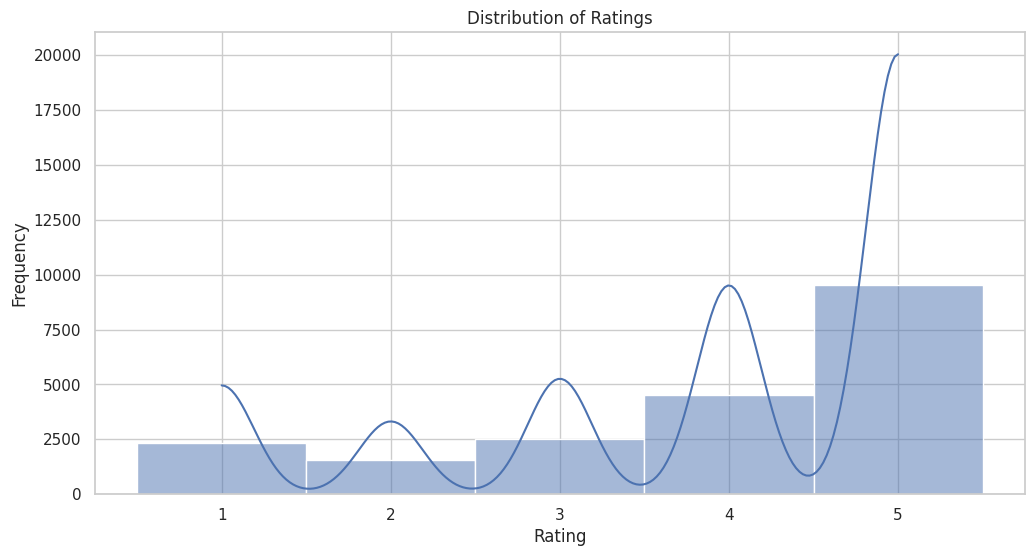

In [34]:
# Setting the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution of ratings
plt.figure(figsize=(12, 6))
sns.histplot(data['rating'], kde=True, discrete=True)
plt.xticks(range(1, 6))
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

### 2.2. Review count over time

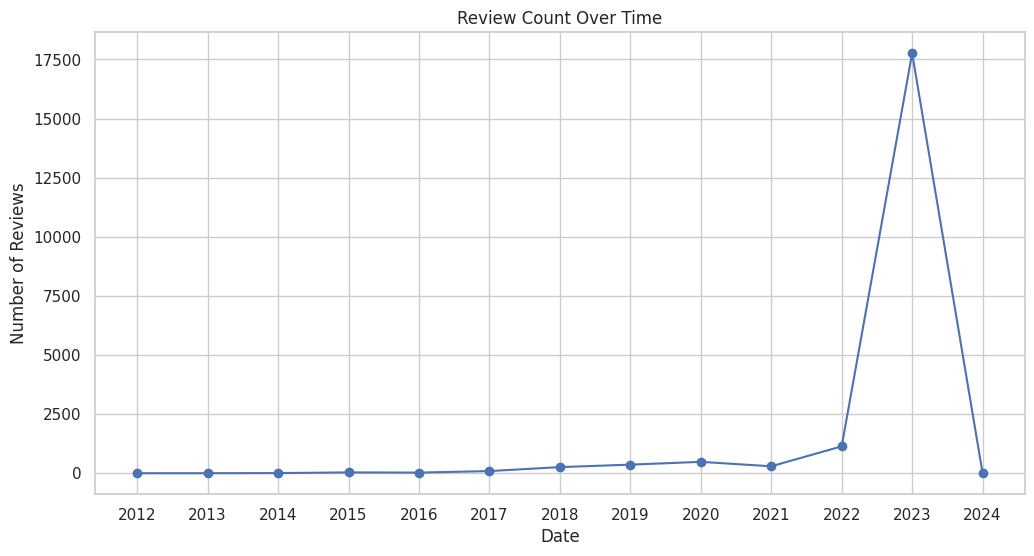

In [35]:
# Review count over time
plt.figure(figsize=(12, 6))
data['review_timestamp'].dt.year.value_counts().sort_index().plot(kind='line', marker='o')
plt.title('Review Count Over Time')
plt.xticks(list(set(data['review_timestamp'].dt.year)), rotation=0, ha='center')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

### 2.3. Trip companions

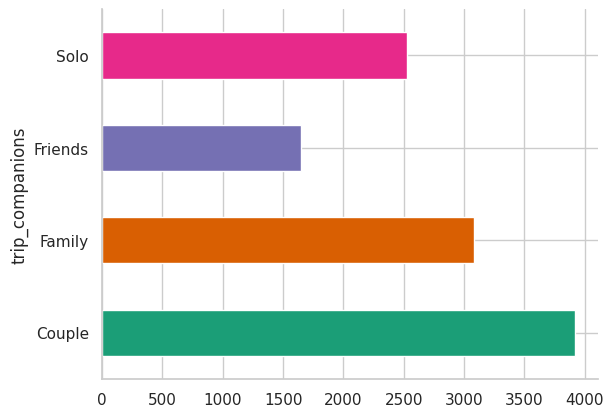

In [36]:
data.groupby('trip_companions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

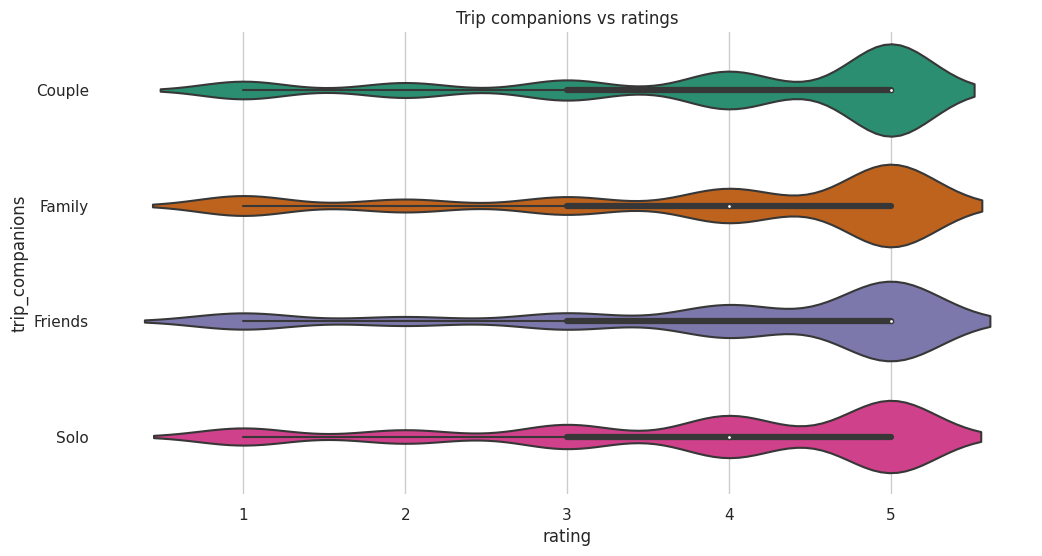

In [37]:
figsize = (12, 1.2 * len(data['trip_companions'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='rating', y='trip_companions', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)
plt.title('Trip companions vs ratings')
plt.show()

## 3. Text Analysis

### 3.1. Text length

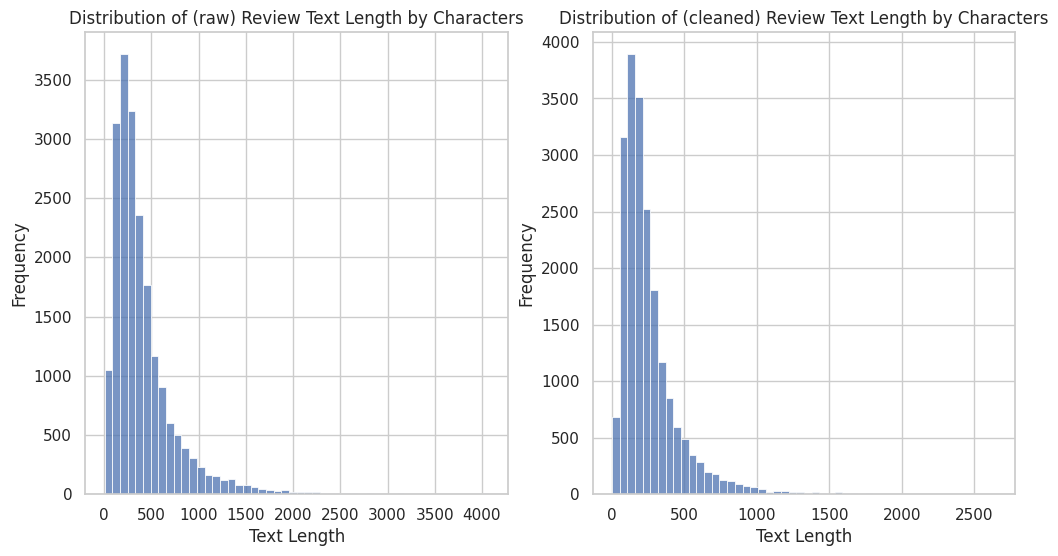

In [38]:
# Generate a histogram of the text lengths
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.histplot(data['review_text'].str.len(), bins=50)
plt.title('Distribution of (raw) Review Text Length by Characters')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.histplot(data['review_text_cleaned'].str.len(), bins=50)
plt.title('Distribution of (cleaned) Review Text Length by Characters')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


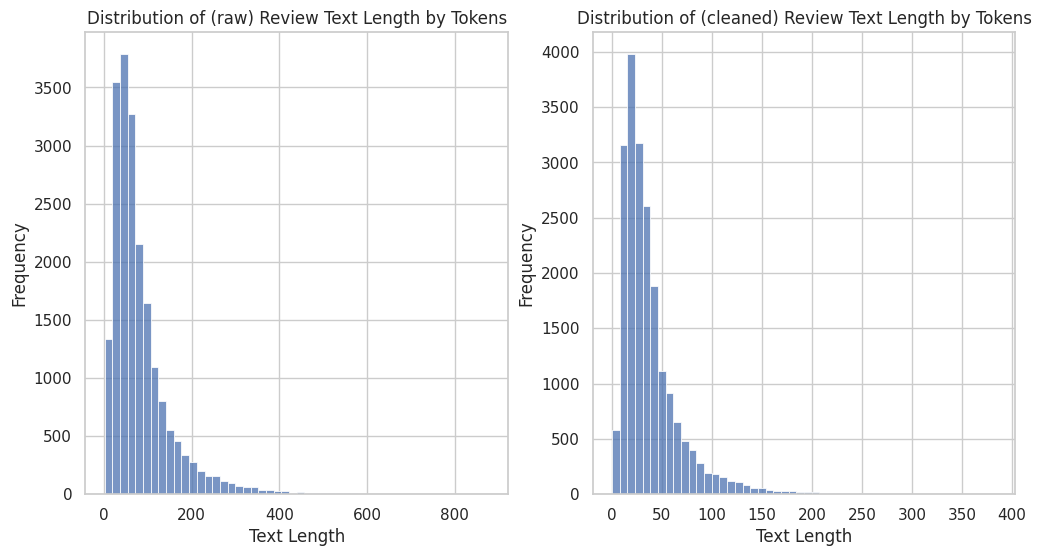

In [39]:
# Generate a histogram of the text lengths by tokens
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
sns.histplot(data['review_text'].apply(cleaner.tokenize).apply(len), bins=50)
plt.title('Distribution of (raw) Review Text Length by Tokens')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.histplot(data['review_text_cleaned'].apply(cleaner.tokenize).apply(len), bins=50)
plt.title('Distribution of (cleaned) Review Text Length by Tokens')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

### 3.2. Common words


Plot a bar chart of the most common words in the reviews. The chart shows the top 10 most frequent words, with some key observations:

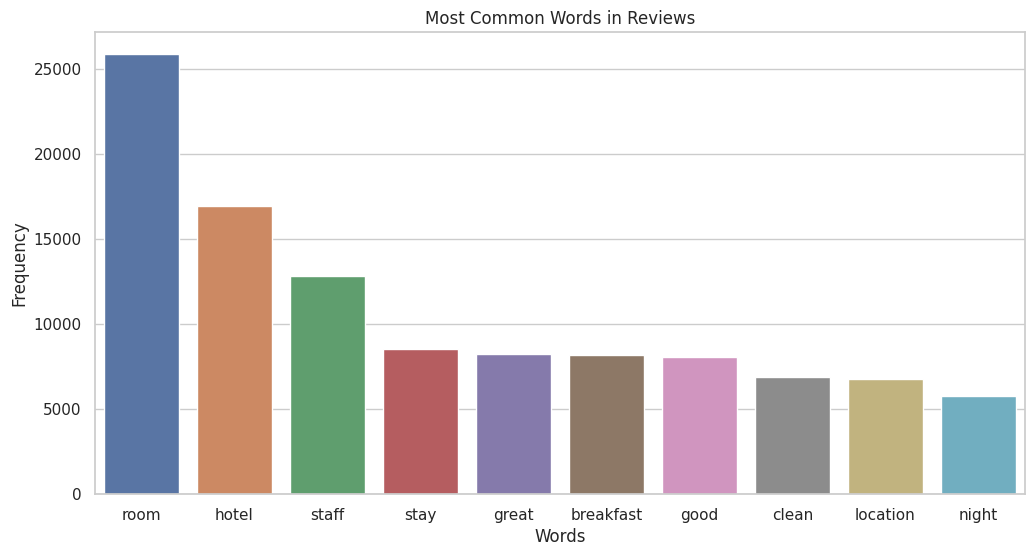

In [40]:
# Finding and displaying the most common words
full_text = ' '.join(data['review_text_cleaned'])
list_words = full_text.split()
common_words = Counter(list_words).most_common(10)

# Plotting the most common words
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.title('Most Common Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

Plot a WordCloud of the most common words in the reviews.

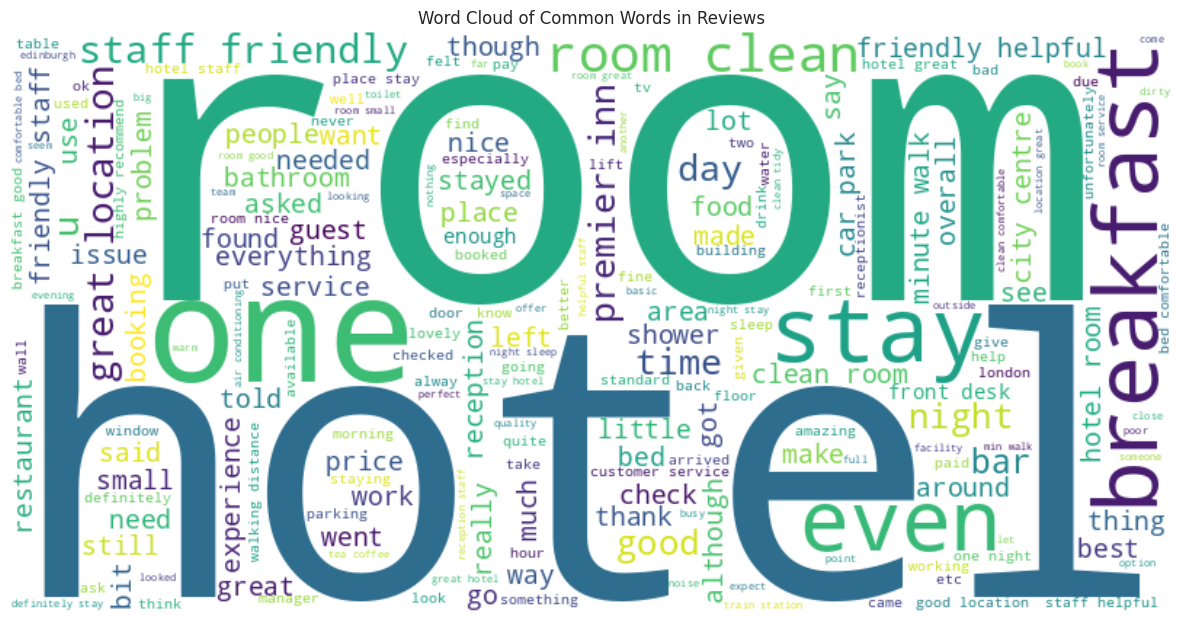

In [41]:
# Creating a word cloud for the most frequent words in the reviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(full_text)

# Displaying the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Words in Reviews')
plt.show()

### 3.3. Sentiment Analysis

**Lexicon-based approach**

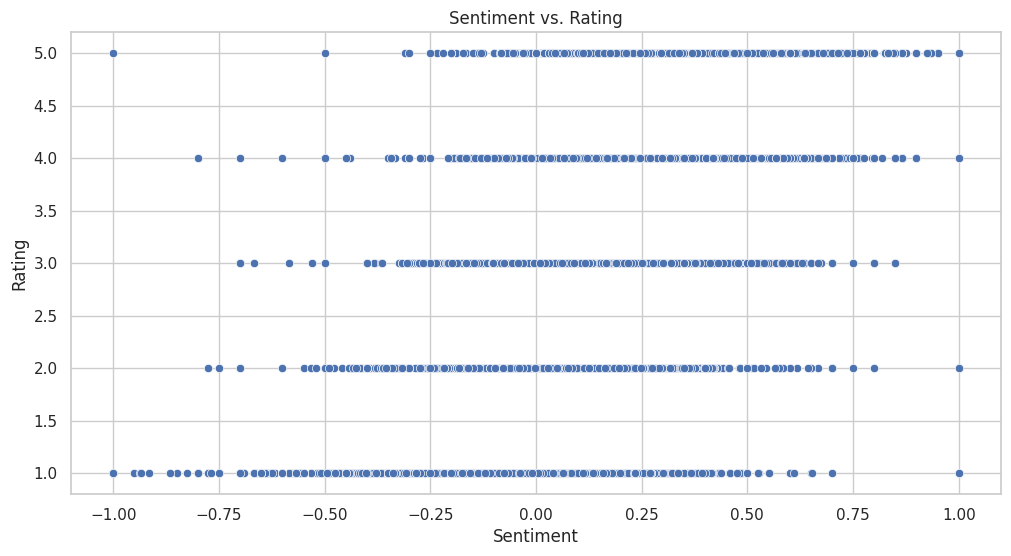

In [42]:
# Sentiment Analysis on Review Text
# Adding a new column 'sentiment' to the data, representing the polarity of the review text
data['sentiment_lexicon_based'] = data['review_text_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting the relationship between Sentiment and Ratings
plt.figure(figsize=(12, 6))
sns.scatterplot(x='sentiment_lexicon_based', y='rating', data=data)
plt.title('Sentiment vs. Rating')
plt.xlabel('Sentiment')
plt.ylabel('Rating')
plt.show()

**Neural-based approach**

In [43]:
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    padding='max_length',
    truncation=True,
    max_length=512,
    device=0,
    batch_size=32
)

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Analyse sentiment of review text and classify them into on of 3 categories: ['positive', 'neural', 'negative']

In [44]:
reviews = list(data['review_text'])
data['sentiment_transformer_based_raw'] = pd.DataFrame(distilled_student_sentiment_classifier(reviews))['label']

In [45]:
data['sentiment_transformer_based_raw'].value_counts()

positive    14811
negative     5183
neutral       480
Name: sentiment_transformer_based_raw, dtype: int64

In [46]:
cleaned_reviews = list(data['review_text_cleaned'])
data['sentiment_transformer_based'] = pd.DataFrame(distilled_student_sentiment_classifier(cleaned_reviews))['label']

In [47]:
data['sentiment_transformer_based'].value_counts()

positive    16652
negative     3778
neutral        44
Name: sentiment_transformer_based, dtype: int64

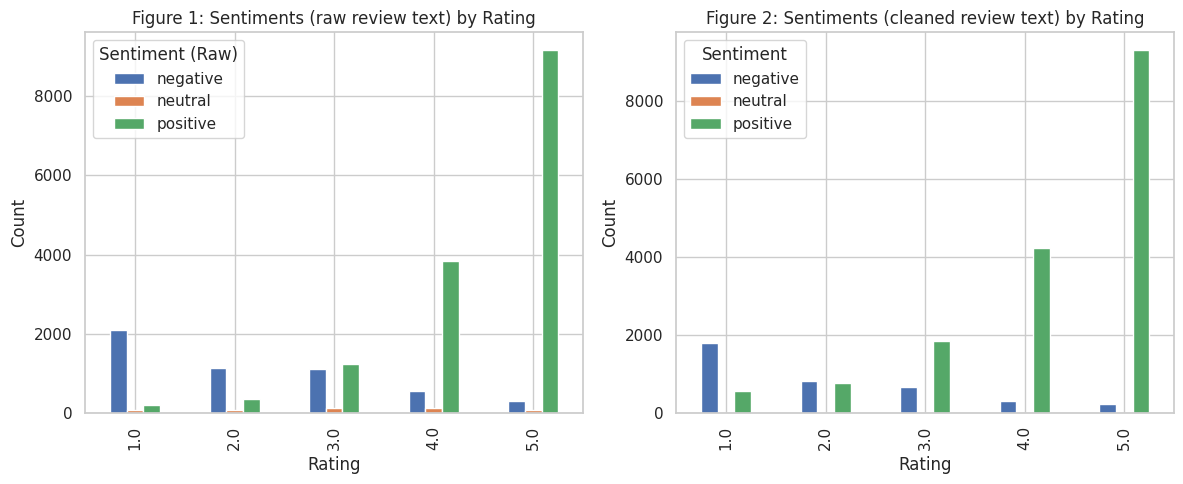

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Figure 1: Distribution of Sentiments by Rating (Left Subplot)
counts1 = data.groupby(['rating', 'sentiment_transformer_based_raw']).size().unstack(fill_value=0)
counts1.plot(kind='bar', stacked=False, ax=axes[0])
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Figure 1: Sentiments (raw review text) by Rating')
axes[0].legend(title='Sentiment (Raw)')

# Figure 2: Distribution of Sentiments by Rating (Right Subplot)
counts2 = data.groupby(['rating', 'sentiment_transformer_based']).size().unstack(fill_value=0)
counts2.plot(kind='bar', stacked=False, ax=axes[1])
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Count')
axes[1].set_title('Figure 2: Sentiments (cleaned review text) by Rating')
axes[1].legend(title='Sentiment')

plt.tight_layout()
plt.show()


## 4. Correlation Analysis

**Trip information**

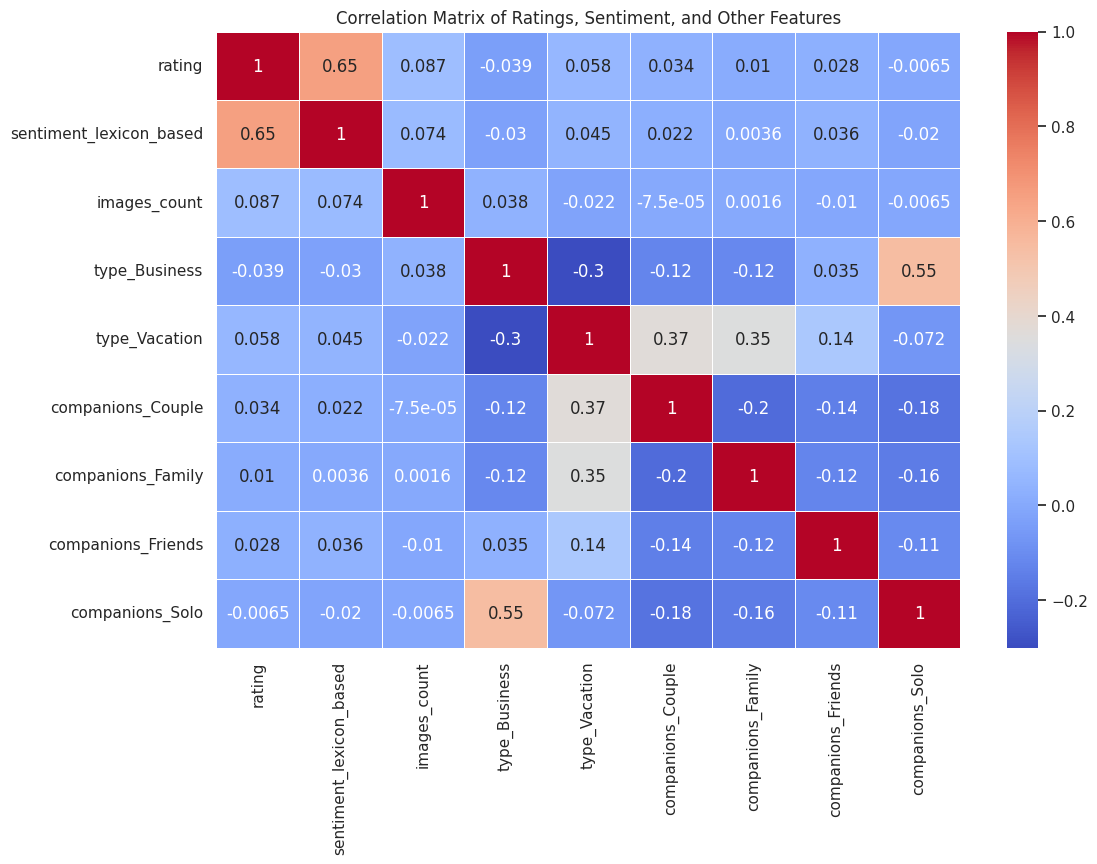

In [49]:
trip_info = data[['rating', 'sentiment_lexicon_based', 'images_count']]

if 'trip_type' in data.columns:
    trip_type_dummies = pd.get_dummies(data['trip_type'], prefix='type')
    trip_info = pd.concat([trip_info, trip_type_dummies], axis=1)

if 'trip_companions' in data.columns:
    trip_companions_dummies = pd.get_dummies(data['trip_companions'], prefix='companions')
    trip_info = pd.concat([trip_info, trip_companions_dummies], axis=1)

# Calculate the correlation matrix for the numerical data
correlation_matrix = trip_info.corr()
correlation_matrix.style.set_precision(2)

# Plotting the correlation matrix using seaborn's heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Ratings, Sentiment, and Other Features')
plt.show()


**Popular Amenities**

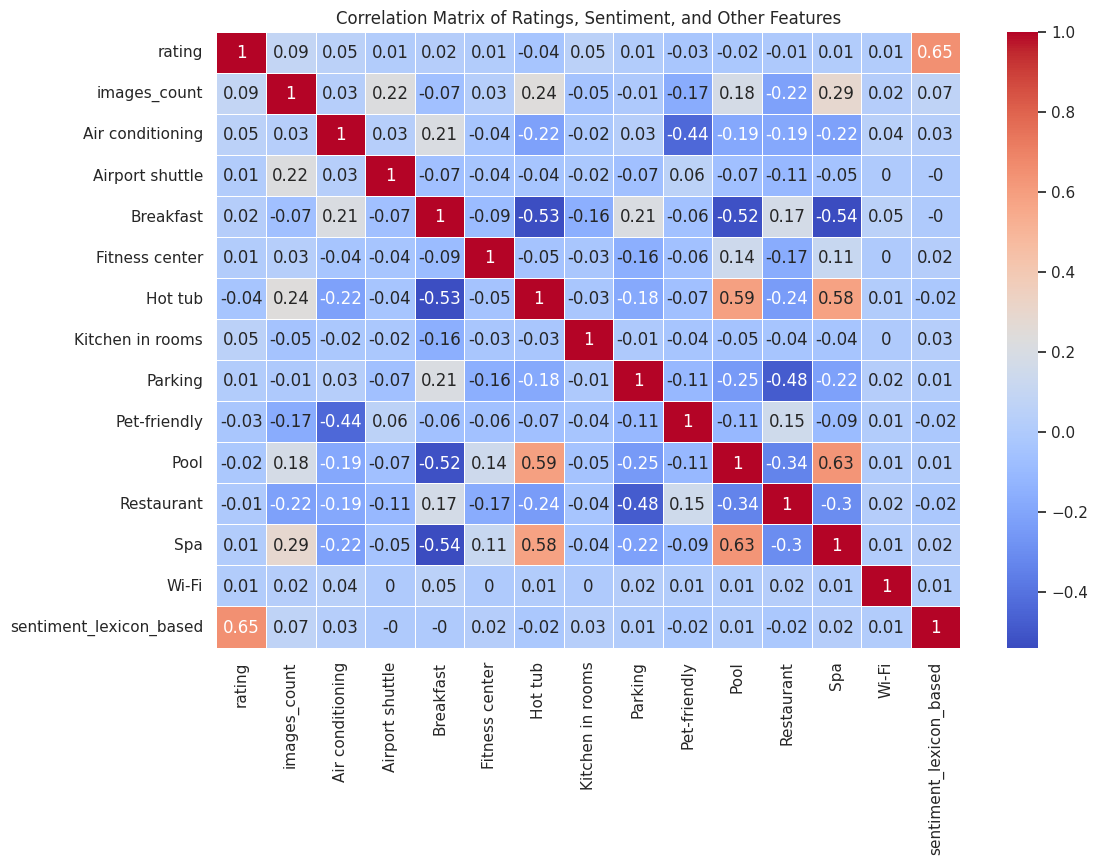

In [50]:
correlation_matrix = data.corr()
correlation_matrix = correlation_matrix.round(2)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Ratings, Sentiment, and Other Features')
plt.show()

# Machine Learning Classifier

## Define train and test set

In [63]:
x = data.loc[:, 'review_text_cleaned'].values
y = data.loc[:, 'sentiment_transformer_based_raw'].values

X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.2,
                                                    random_state = 0)

##Deploying NB model with Bow

Vectorize reviews data with `CountVectorizer`

In [64]:
# Learn representation from whole data
count_vect = CountVectorizer().fit(x)

#Fitting and transforming input data
bow_train = count_vect.transform(X_train).toarray()
bow_test = count_vect.transform(X_test).toarray()

Train Naive Bayes model

In [65]:
# instantiate the model
NB = GaussianNB()

# fit the model with data
NB.fit(bow_train, y_train)

GaussianNB()

Evaluate model

In [66]:
predicted_NB = NB.predict(bow_test)
print(classification_report(y_test, predicted_NB))

              precision    recall  f1-score   support

    negative       0.31      0.78      0.45      1019
     neutral       0.03      0.14      0.04       110
    positive       0.81      0.27      0.40      2966

    accuracy                           0.39      4095
   macro avg       0.38      0.39      0.30      4095
weighted avg       0.66      0.39      0.40      4095



##Deploying NB model with Tfidf

Vectorize reviews data with `TfidfVectorizer`

In [67]:
# Learn representation from whole data
tfidf = TfidfVectorizer().fit(x)

#Fitting and transforming input data
tfidf_train = tfidf.transform(X_train).toarray()
tfidf_test = tfidf.transform(X_test).toarray()

Train Naive Bayes model

In [68]:
# instantiate the model
NB = GaussianNB()

# fit the model with data
NB.fit(tfidf_train, y_train)

GaussianNB()

Evaluate model

In [69]:
predicted_NB = NB.predict(tfidf_test)
print(classification_report(y_test, predicted_NB))

              precision    recall  f1-score   support

    negative       0.32      0.74      0.45      1019
     neutral       0.03      0.14      0.04       110
    positive       0.81      0.32      0.46      2966

    accuracy                           0.42      4095
   macro avg       0.39      0.40      0.32      4095
weighted avg       0.67      0.42      0.45      4095

